<a href="https://colab.research.google.com/github/eitanfass/Tomato_quality/blob/main/NI_R2_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
#from sklearn.metrics import r2_score
from scipy import stats
import numpy as np
#import math
from google.colab import drive
drive.mount('/content/drive')
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin,mean_squared_error,silhouette_score
from sklearn.cluster import KMeans
import pylab as pl
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

Mounted at /content/drive


In [ ]:
pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 4.9 MB/s 


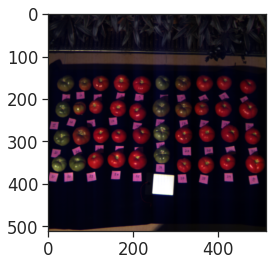

In [ ]:
from spectral import *

input_file='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/RAW_SPECTRAL_DATA/22_6_22 SOLI/1373/results/REFLECTANCE_1373.hdr'
img = open_image(input_file)
arr=np.array(img.load())
arr=np.rot90(arr[:,:,:],3)
RGB=np.zeros([512,512,3],dtype=float)
RGB[:,:,0]=arr[:,:,80]
RGB[:,:,1]=arr[:,:,40]
RGB[:,:,2]=arr[:,:,2]
plt.imshow(RGB)



In [ ]:
from spectral import *
def read_spectral_img(hdr_file_path):
  img = open_image(hdr_file_path)
  arr=np.array(img.load())
  arr=np.rot90(arr[:,:,:],3)#rotate 
  RGB=np.zeros([512,512,3],dtype=float)# create tamplate for RGB
  RGB[:,:,0]=arr[:,:,80]#red 
  RGB[:,:,1]=arr[:,:,40]#green
  RGB[:,:,2]=arr[:,:,5]#blue
  return arr, RGB



#data orgenazation functions

In [ ]:
def plot_all_reflectence(df1):# plots all reflectence data in the above format, wave df is requaired
  global wave_df
  fig, ax = plt.subplots(figsize=(10,7))
  df=df1.T
  x=list(np.arange(0,204,50,dtype=int))
  for i in df.columns:
    ax.plot(df[i])
    plt.axvline(x=23,color='b',lw=5)
    plt.axvline(x=47,color='g',lw=5)
    plt.axvline(x=80,color='r',lw=5)
  ax.set(xlabel='Wavelangth (nm)',
        ylabel='Reflectence'
        )
  plt.xticks(ticks=x, labels
            =wave_df.loc[x]['wavelangth']//10*10);
def drop_negetive(df):
  '''drops negetiv values from df'''
  col=df.columns
  j=0
  for i in df[col[-1]]:
    if i<0:
      df.drop([j], axis=0, inplace=True)
    j+=1
  return df
def add_ref_to_res(ref,res):
  '''ref=reflectence df ,res= results df in the format mentioned
  returns a dictionery with reflectence and result, for each result parameter'''
  bwr={}#bands with result united
  length=ref.shape[0]
  new_index=np.arange(0,length)
  ref=ref.set_index(new_index)
  res=res.set_index(new_index)
  for i in res.columns:
    if i=='ID':
      continue
    bwr[i]=pd.concat([ref,res[i]],axis=1)
  return bwr

#functions that create the colormaps np.arrays two input options

In [ ]:

def one_result_test(df):
  ''' input df created in the add_ref_to_res function, 
  returns r_2,R,rmse,spearsman color maps and b1,b2 of highest R2'''
  df=df.dropna(axis=0)
  r_2 = np.arange(41616).reshape(204, 204)
  r_2=np.float16(r_2)
  rmse = np.arange(41616).reshape(204, 204)
  rmse=np.float16(rmse)
  R = np.arange(41616).reshape(204, 204)
  R=np.float16(R)
  spear = np.arange(41616).reshape( 204, 204)
  spear=np.float16(spear)
  col=df.columns
  np_results=np.array(df[col[-1]], dtype=float)
  df_r=np.array(df[col[0:-1]], dtype=float)
  r_2_max,b1,b2=0,0,0
  for j in range(204):#running all combinations
    for y in range (204):
            # np_results[:,np_results != np.array(None)]
            n=(df_r[:,y]-df_r[:,j])/(df_r[:,y]+df_r[:,j])
            slope, intercept, r_value, p_value, std_err = stats.linregress(n
            ,np_results) 
            spear[y,j],p_val= stats.spearmanr(n, b=np_results)
            r_2[y,j] =  r_value**2
            if r_2[y,j]>r_2_max:
              r_2_max=r_2[y,j]
              b1,b2=y,j
            R[y,j]=r_value
            rmse[y,j] =np.sqrt(((np_results-(intercept + (slope * n)))**2).mean())
  return r_2,R,rmse,spear,b1,b2
  

In [ ]:

def R2_R_rmse(reflectence, results):
  '''enter reflectence and results and get array maps of r2 r rmse and spearsman and b1,b2 of best R2'''
  sample_size=len(reflectence)
  if isinstance(results, pd.core.series.Series):
    l=1
  else: l=len(results.columns)
  r_2 = np.arange(41616*l).reshape(l, 204, 204)
  r_2=np.float16(r_2)
  rmse = np.arange(41616*l).reshape(l, 204, 204)
  rmse=np.float16(rmse)
  R = np.arange(41616*l).reshape(l, 204, 204)
  R=np.float16(R)
  spear = np.arange(41616*l).reshape(l, 204, 204)
  spear=np.float16(spear)
  np_results=np.array(results, dtype=float)
  df_r=np.array(reflectence)
  for col in range(l):
    r_max,r_min,b1,b2=0,0,0,0
    for j in range(204):
      for y in range (204):
              # np_results[:,np_results != np.array(None)]
              n=(df_r[:,y]-df_r[:,j])/(df_r[:,y]+df_r[:,j])
              slope, intercept, r_value, p_value, std_err = stats.linregress(n
              ,np_results[:,col]) 
              spear[col,y,j],p_val= stats.spearmanr(n, b=np_results[:,col])
              r_2[col,y,j] =  r_value**2
              R[col,y,j]=r_value
              rmse[col,y,j] =np.sqrt(((np_results[:,col]-(intercept + (slope * n)))**2).mean())
              if  np.abs(R[col,y,j])>r_max:
                r_max= np.abs(R[col,y,j])
                b1,b2=y,j
  return r_2,R,rmse,spear,b1,b2
                


#Ploting functions for colormaps and regression

In [ ]:
def plot_examples(map,map_name,map_stat):#function that takes colormap('varids','blues'...), the map of values,map name, and map max value and creats a color map
    """
    Helper function to plot data with associated colormap.
    """
    global waves
    colormaps=[cm.get_cmap('viridis', 256)]
    data = pd.DataFrame(data=map,index=waves,columns=waves)
    n = len(colormaps)
    
    mask =  np.tri(data.shape[0], k=-1)
    data= np.ma.array(data.T, mask=mask)
    fig, axs = plt.subplots(1,n, figsize=(10, 10),
                constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        
        psm = ax.pcolormesh(waves,waves,data, cmap=cmap, rasterized=True, vmin=data[~np.isnan(data)].min(), vmax=data[~np.isnan(data)].max())
        fig.colorbar(psm, ax=ax)
    plt.title(map_stat+' of normalized index with '+str(map_name))
    plt.xlabel('Band 1 (nm)')
    plt.ylabel('Band 2 (nm)')
    plt.show()

In [ ]:
def regretionplot(B1,B2, data_dict):
  '''creats a regretssion plot,
   colors the samples by their red index values from green to red,
    data_dict in format of add_res_to_ref function'''
  global waves
  palette = {1:"lime",2:"orange",3:"tomato",4:"red"}#,2:"orangered",4:"darkorange",6:"gold"
  for k,v in data_dict.items():
    if k=='ID':
      continue
    v=v.dropna(axis=0)
    col =v.columns
    ref=np.array(v[col[0:-1]])
    result=np.array(v[col[-1]])
    n=((ref[:,B1[k]]-ref[:,B2[k]])/(ref[:,B1[k]]+ref[:,B2[k]]))
    l=(ref[:,80]-ref[:,40])/(ref[:,80]+ref[:,40])
    l1=l-l.min()
    num=(l1.max()/4)+0.00001
    l1=(l1//num)+1
    x_tag=  'NI'
    dict={x_tag:n,k:result, 'Color':l1}
    data=pd.DataFrame(dict)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x_tag],data[k])
    sns.lmplot(x=x_tag, y=k, hue="Color", data=data,palette=palette, fit_reg=False, legend=False)#x_estimator=np.mean
    plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':100})
    ax = sns.regplot(x=x_tag
    , y=k, data=data, scatter_kws={"zorder":-1},
    line_kws={'color': 'black','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    ax.text(0.18, 1.05, "R=: {:.2f}   P-value= {:.4f} ".format(r_value,p_value), ha="left", va="top",fontsize=15, transform=ax.transAxes)
    ax.text(0.20, 1, "bands=({:.0f}nm,{:.0f}nm)".format(waves[B1[k]],waves[B2[k]]), ha="left", va="top",fontsize=15, transform=ax.transAxes)
    # plt.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)



#opening filesand formating

In [ ]:
# =================== geting reflectence data into a df with 204 bads as columns and samples as rows=======================
#====================result data is dtored in a df where columns are results and rows are samples===========================
global waves
global wave_df
df_ref=  pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Reflectence_ID1_320.csv') 
df_stdv=  pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/STDV_ID1_320.csv') 
df_medien=  pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Median_ID1_320') 
wave_df=pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/chennel chart.csv')
smallexp_ref=pd.read_csv("/content/drive/MyDrive/Shared_tomato/Eitan/LEKET_FARM_15_08_2021/SPECTRAL_DATA/reflectence_mean_ID1_27.csv")
soli_results=pd.read_csv("/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Lab/chemical_results_soli_id_1_40.csv")

soli_ref=pd.read_csv("/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/2022_6_22_SOLI_Medien_ID1_40.csv")
col=df_ref.columns
df_ref=df_ref.drop([col[0]], axis=1)
col=df_ref.columns

smallexp_ref=smallexp_ref.drop(['Unnamed: 0'],axis=1)
soli_ref=soli_ref.drop(['Unnamed: 0'],axis=1)
soli_ref=soli_ref.T
waves=[float(i) for i in wave_df['wavelangth'] ]
smallexp_ref=smallexp_ref.T
df_results=  pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/VOLCANI_CENTER/CHEMICAL _RESULTS_ROMA_AS_200_13_10_2021_ID_1_320.csv')
smallexp_results= pd.read_csv('/content/drive/MyDrive/Shared_tomato/1_Data_shared/2021/2021_08_15/LEKET/Lab/2021_08_15_LEKET_ID1_27.csv')
names=list(df_results.columns.values)
df_results=df_results.drop(['ID'],axis=1)
df_ref=df_ref.T
smallexp_results=smallexp_results.drop(['ID'],axis=1)
soli_results=soli_results.drop(['ID'],axis=1)
soli_2_ref=pd.read_csv('/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Spectral/Lab_Images/2022_10_19_SOLI_industial_Mean_ID1_60.csv')
soli_2_results=pd.read_csv('/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Lab/2022_10_19_Chemical_Results_SOLI_industrial_ID1_60.csv')
soli_2_results=soli_2_results.drop(['ID'],axis=1)
soli_2_ref=soli_2_ref.drop(['Unnamed: 0'],axis=1)
soli_2_ref=soli_2_ref.T



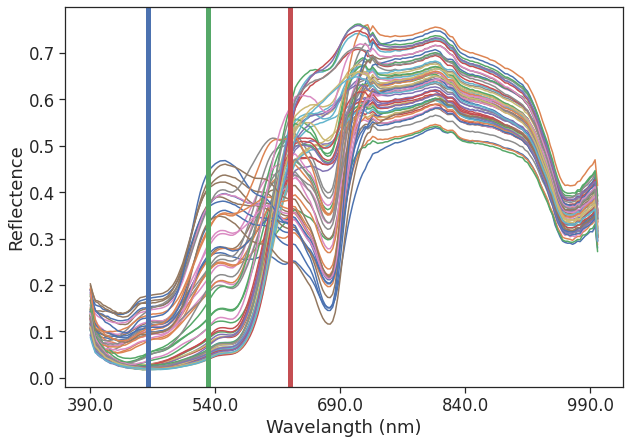

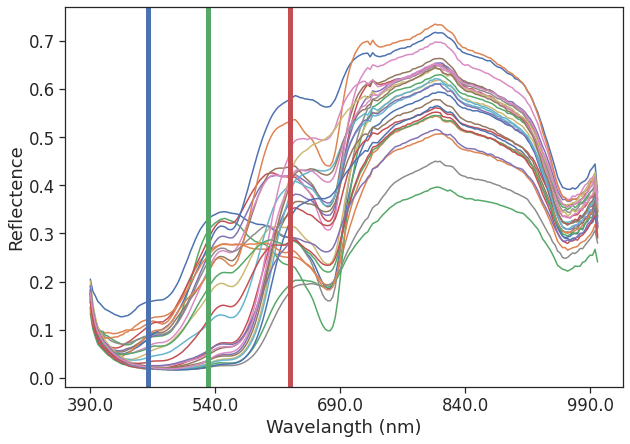

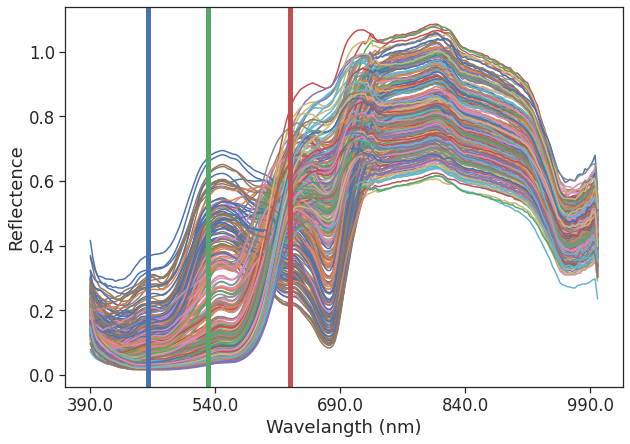

In [ ]:


plot_all_reflectence(soli_ref)
plot_all_reflectence(smallexp_ref)
plot_all_reflectence(df_ref)

creating PCA, and standerdazind the data:

In [ ]:
smallexp_ref_copy=smallexp_ref.set_index(np.arange(321,348))
soli_ref_copy=soli_ref.set_index(np.arange(348,388))
soli_2_ref_copy=soli_2_ref.set_index(np.arange(388,448))
smallexp_results_copy=smallexp_results.set_index(np.arange(321,348))
soli_results_copy=soli_results.set_index(np.arange(348,388))
soli_2_results_copy=soli_2_results.set_index(np.arange(388,448))
roma_ref=pd.concat([df_ref,smallexp_ref_copy])
united_ref=pd.concat([df_ref,smallexp_ref_copy,soli_ref_copy,soli_2_ref_copy])
united_results=pd.concat([df_results,smallexp_results_copy,soli_results_copy,soli_2_results_copy])
roma_results=pd.concat([df_results,smallexp_results_copy])


In [ ]:

roma_1_ref_res=add_ref_to_res(smallexp_ref,smallexp_results)# creating dictioneries for the R2 maps with reflectence and results 
roma_2_ref_res=add_ref_to_res(df_ref,df_results)
soli_2_ref_res=add_ref_to_res(soli_2_ref,soli_2_results)
roma_ref_res=add_ref_to_res(roma_ref,roma_results)
united_ref_res=add_ref_to_res(united_ref,united_results)
soli_ref_res=add_ref_to_res(soli_ref,soli_results)


#applying color maps to data


##Harvest 1 color maps and scatter plots

###colormap

In [ ]:
# viridis = cm.get_cmap('viridis', 256)
B1={}
B2={}
save={}
map_type=['RMSE','R','$R^2$','Spearmans corrolation']
for k,v in roma_1_ref_res.items():
  if k=='ID':
    continue
  r_2,R,rmse,spear,b1,b2=one_result_test(drop_negetive(v))
  print(f'results for {k}:/n R^2 ={r_2.max()}/n R (max, min)={R.max(),R.min()}\n rmse={rmse[~np.isnan(rmse)].min()}/n b1={b1}/n b2={b2}')
  B1[k]=b1
  B2[k]=b2
  save[k]=[rmse,R,r_2,spear]
  stats_names={'1':rmse,'2':R,'3':r_2,'4':spear}
  for j,name in zip(stats_names.values(),map_type):
      plot_examples(j,k,name)

###scatter plots

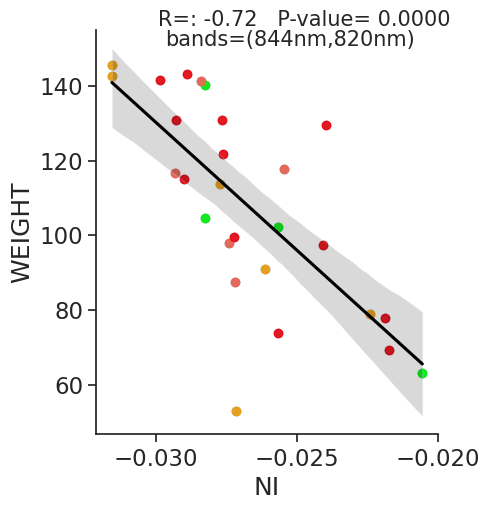

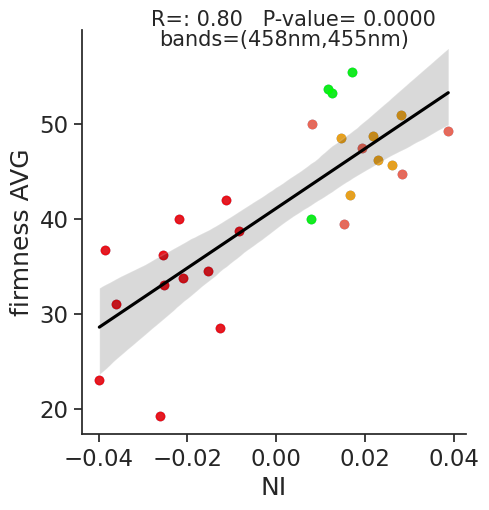

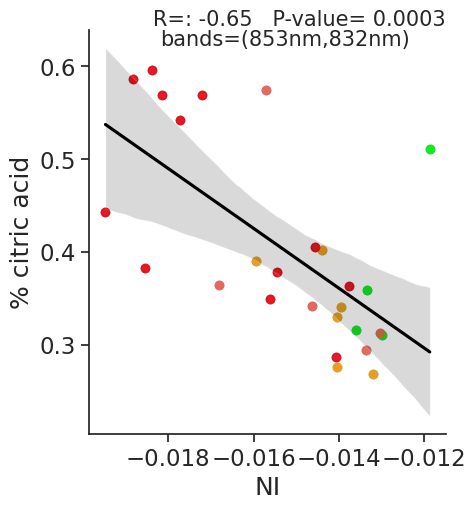

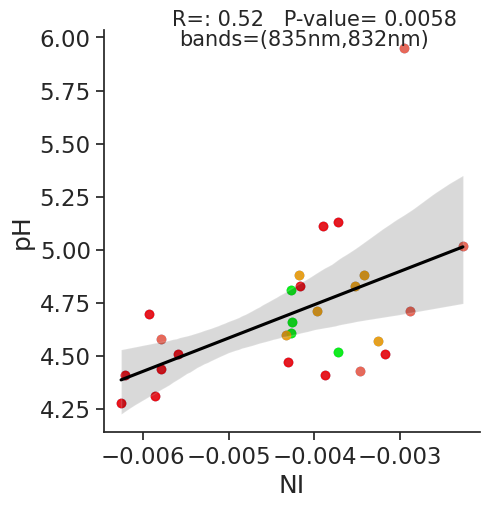

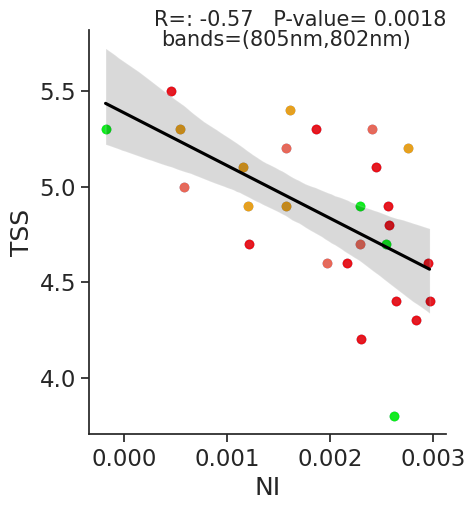

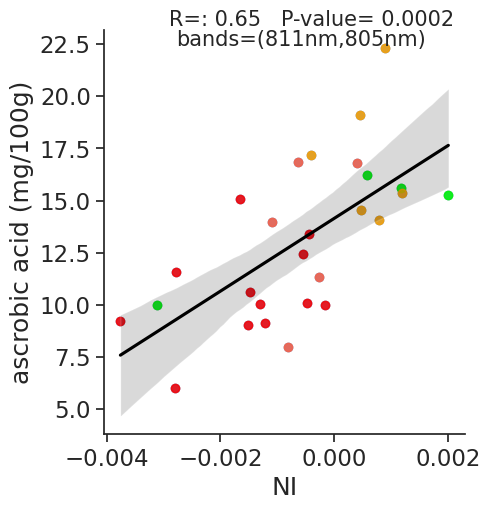

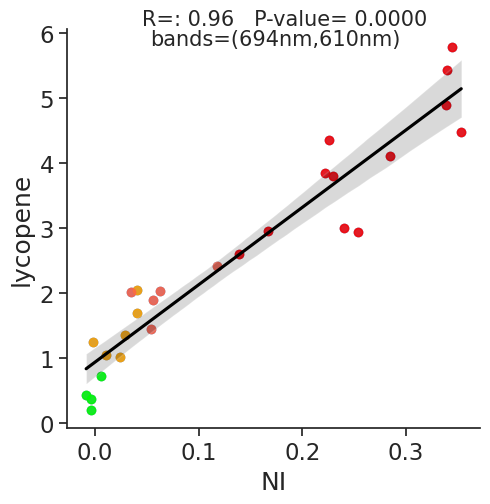

In [ ]:
regretionplot(B1,B2, roma_1_ref_res)

##Harvest 2 color maps and scatter plots

###color map

In [ ]:
# viridis = cm.get_cmap('viridis', 256)
B1={}
B2={}
save={}
map_type=['RMSE','R','$R^2$','Spearmans corrolation']
for k,v in roma_2_ref_res.items():
  if k=='ID':
    continue
  r_2,R,rmse,spear,b1,b2=one_result_test(drop_negetive(v))
  print(f'results for {k}:\n $$R^2$$ ={r_2.max()}\n R (max, min)={R.max(),R.min()}\n rmse={rmse[~np.isnan(rmse)].min()}/n b1={b1}/n b2={b2}')
  B1[k]=b1
  B2[k]=b2
  save[k]=[rmse,R,r_2,spear]
  stats_names={'1':rmse,'2':R,'3':r_2,'4':spear}
  for j,name in zip(stats_names.values(),map_type):
      plot_examples(j,k,name)

###scatter plot

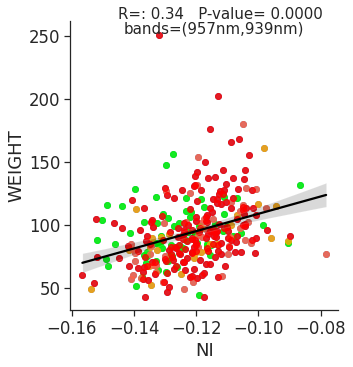

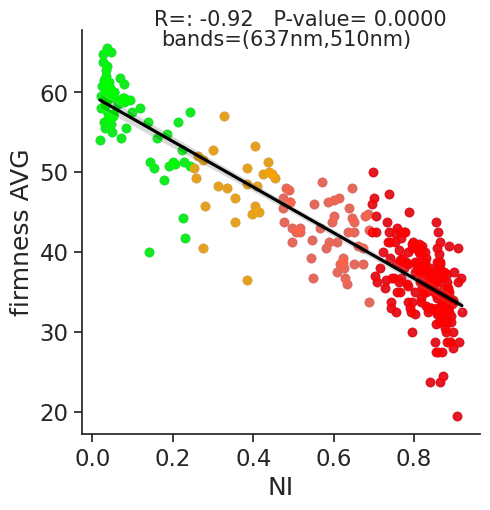

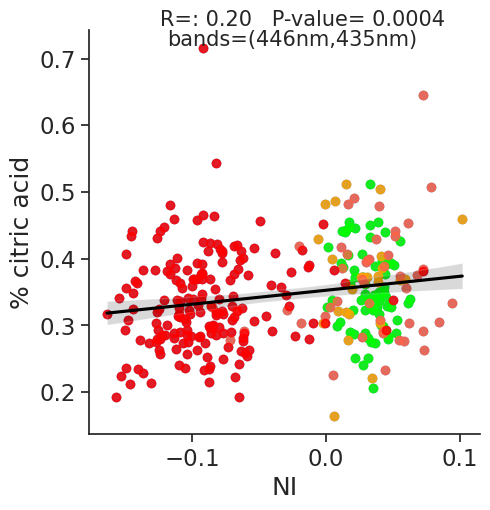

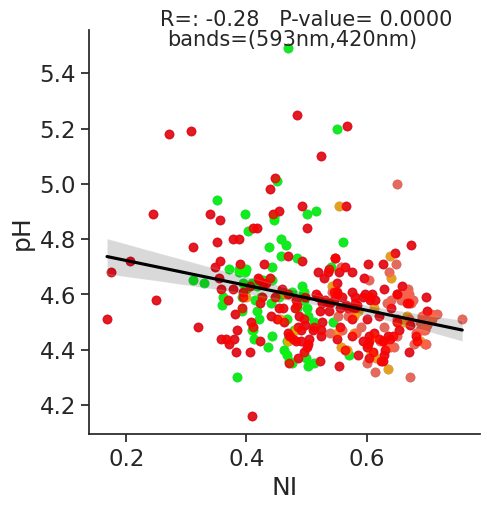

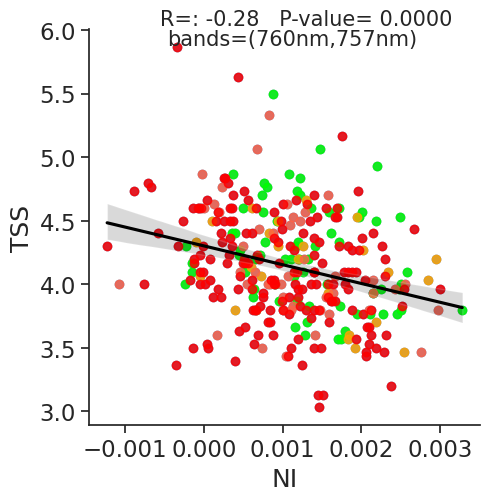

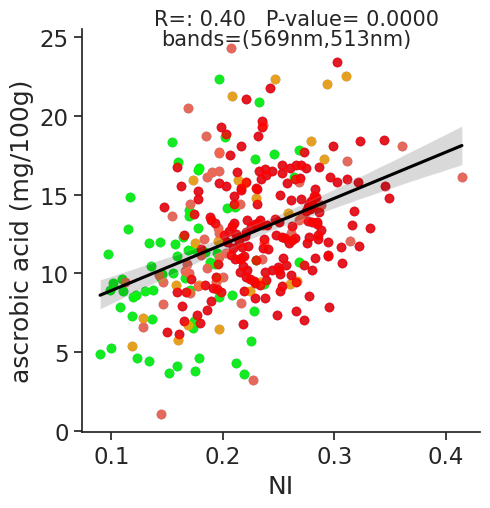

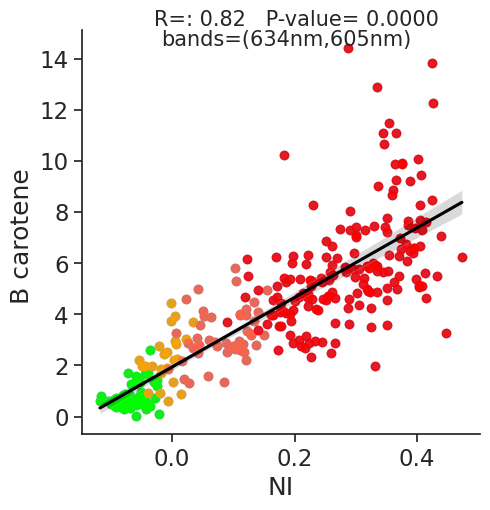

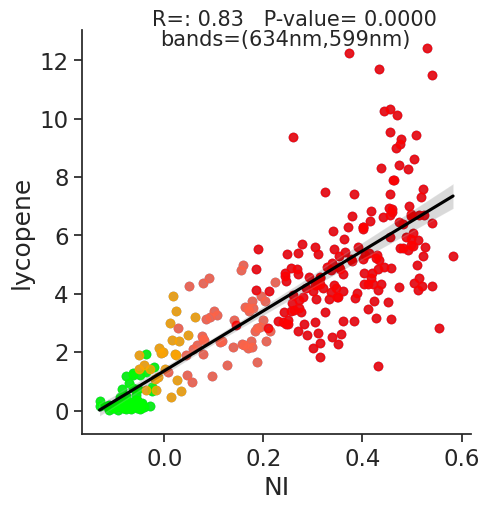

In [ ]:
for i in roma_2_ref_res.values():
  i=drop_negetive(i)
regretionplot(B1,B2, roma_2_ref_res)

##Harvest 3 color maps and scatter plots

###color map

In [ ]:
# viridis = cm.get_cmap('viridis', 256)
B1={}
B2={}
save={}
map_type=['RMSE','R','$R^2$','Spearmans corrolation']
for k,v in soli_ref_res.items():
  if k=='ID':
    continue
  r_2,R,rmse,spear,b1,b2=one_result_test(v)
  print(f'results for {k}:\n $$R^2$$ ={r_2.max()}\n R (max, min)={R.max(),R.min()}\n rmse={rmse[~np.isnan(rmse)].min()}/n b1={b1}/n b2={b2}')
  B1[k]=b1
  B2[k]=b2
  save[k]=[rmse,R,r_2,spear]
  stats_names={'1':rmse,'2':R,'3':r_2,'4':spear}
  for j,name in zip(stats_names.values(),map_type):
      plot_examples(j,k,name)

###scater plot

In [ ]:
regretionplot(B1,B2, soli_ref_res)

##Harvest 4 color maps and scatter plots

###color maps

/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


results for WEIGHT:
 $$R^2$$ =0.2314453125
 R (max, min)=(0.4812, -0.4812)
 rmse=13.890625/n b1=48/n b2=39


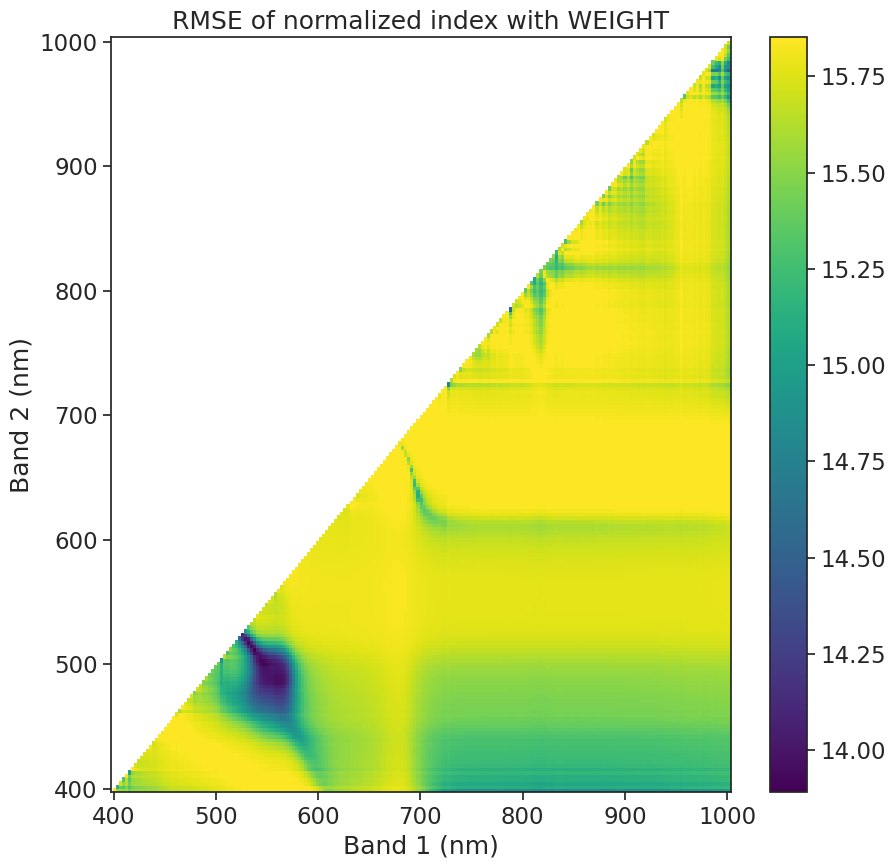

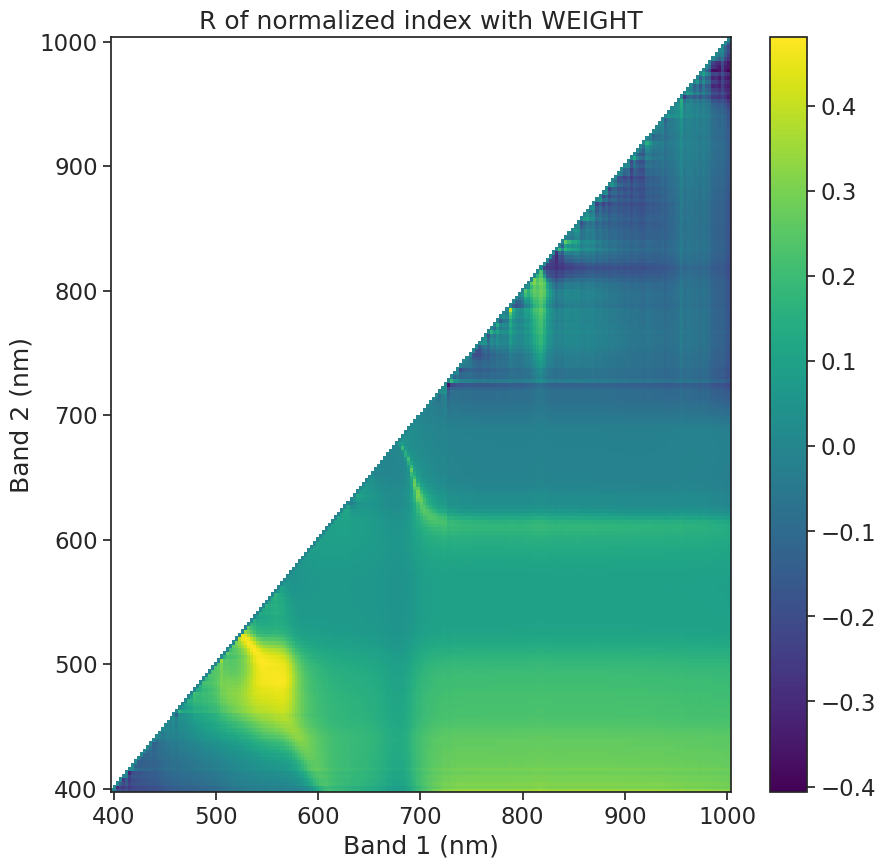

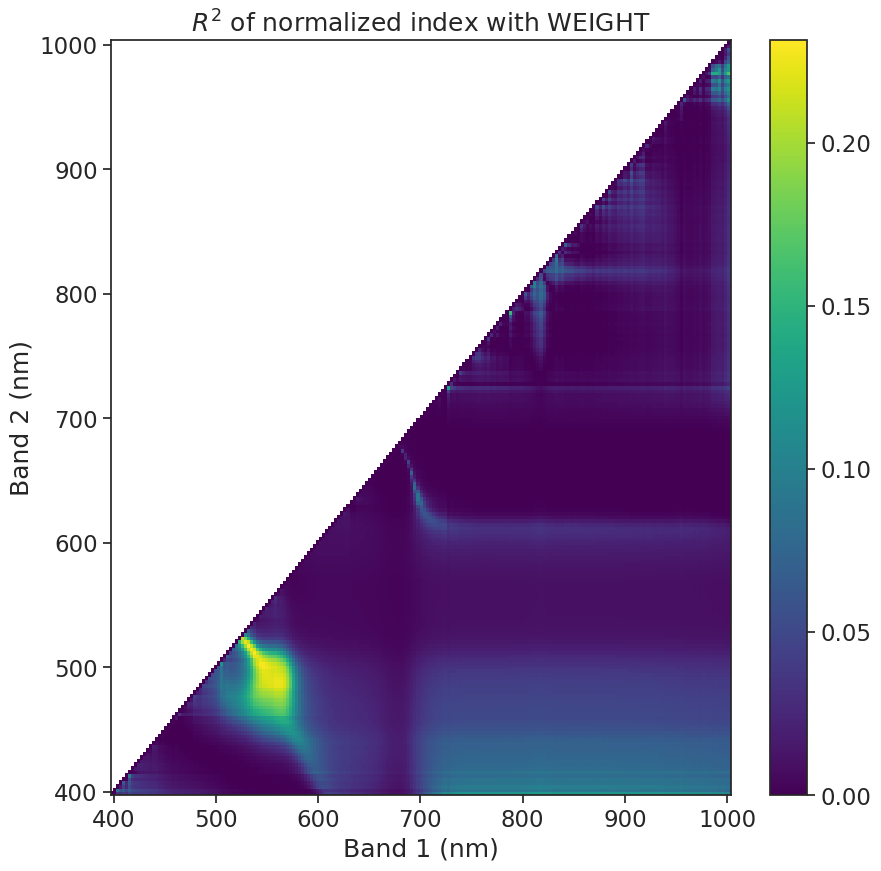

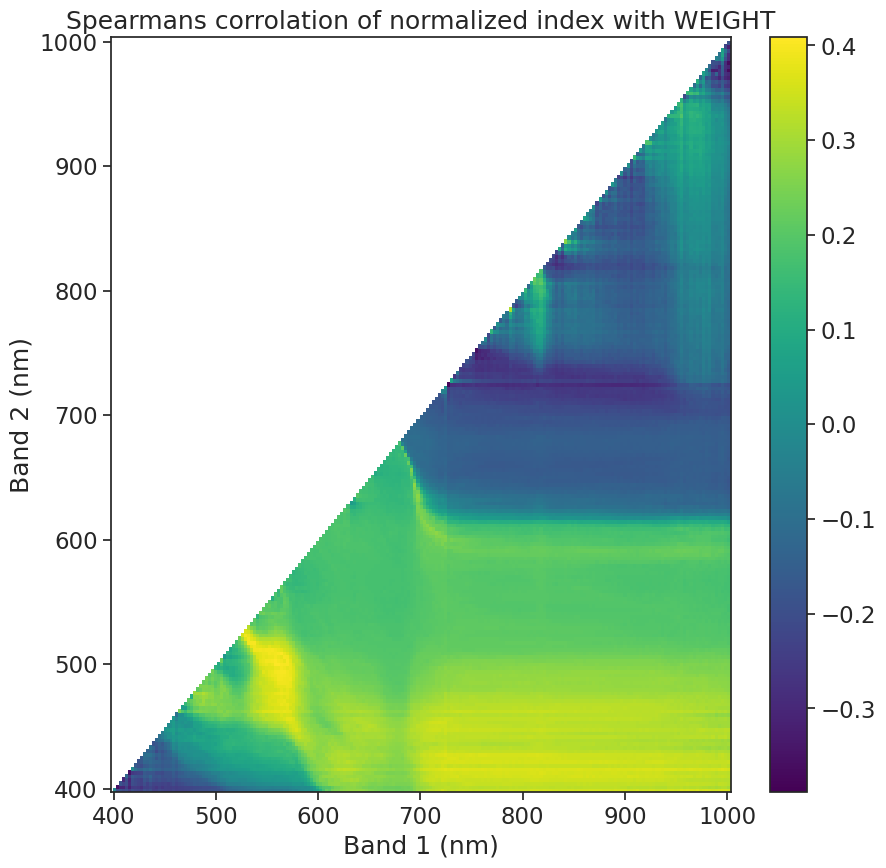

results for firmness AVG:
 $$R^2$$ =0.92724609375
 R (max, min)=(0.963, -0.963)
 rmse=2.970703125/n b1=101/n b2=65


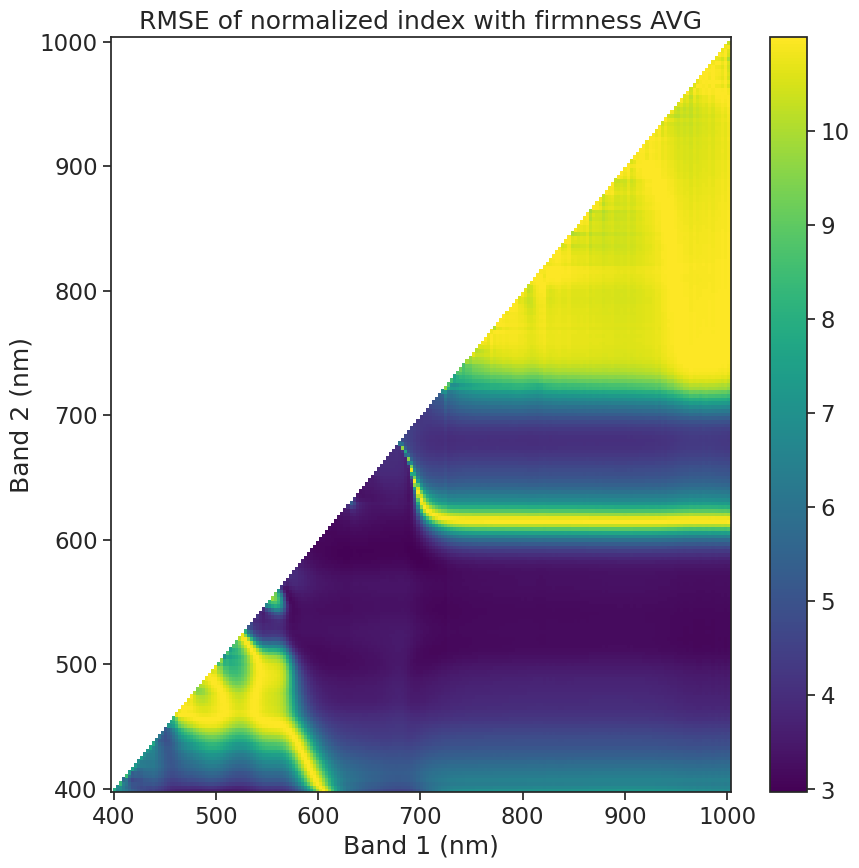

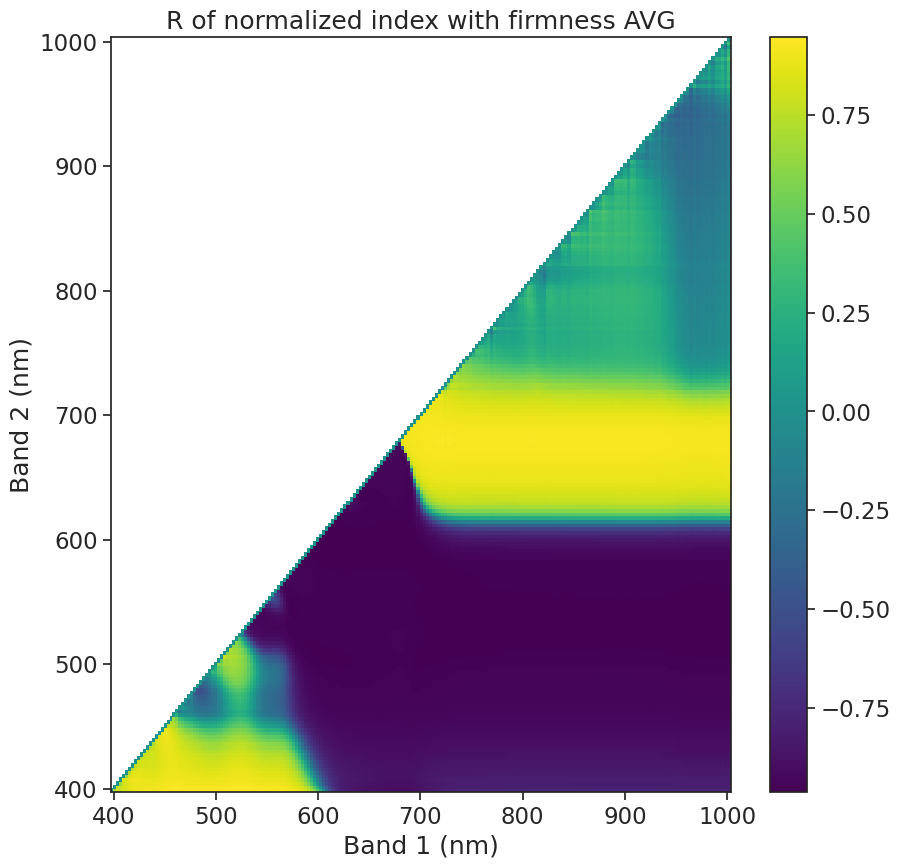

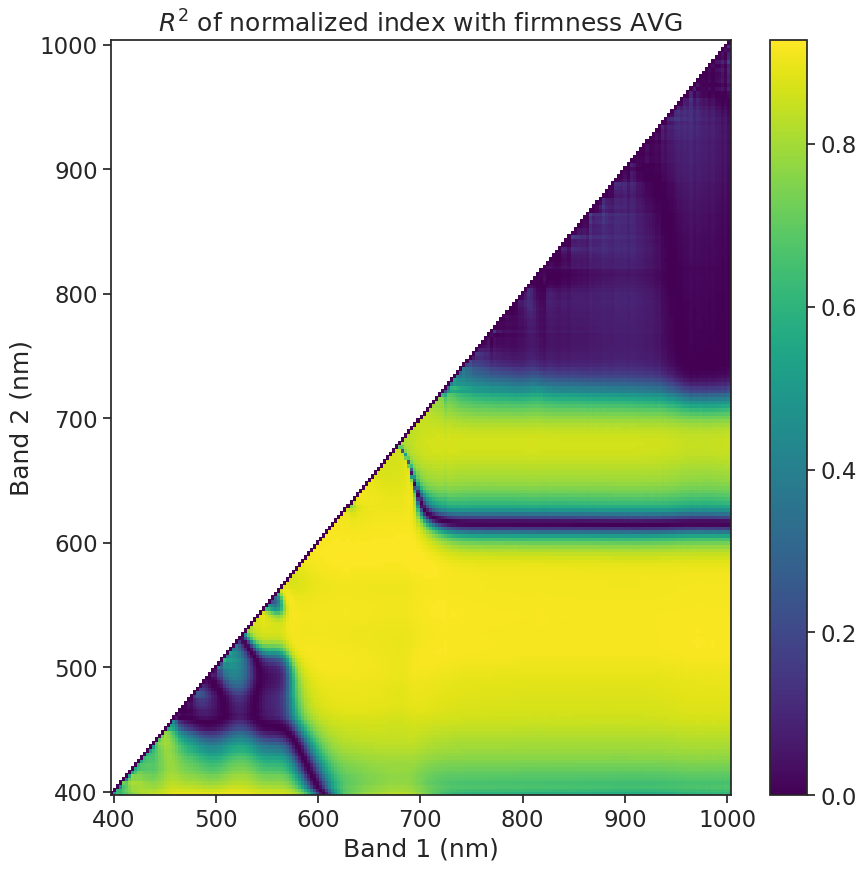

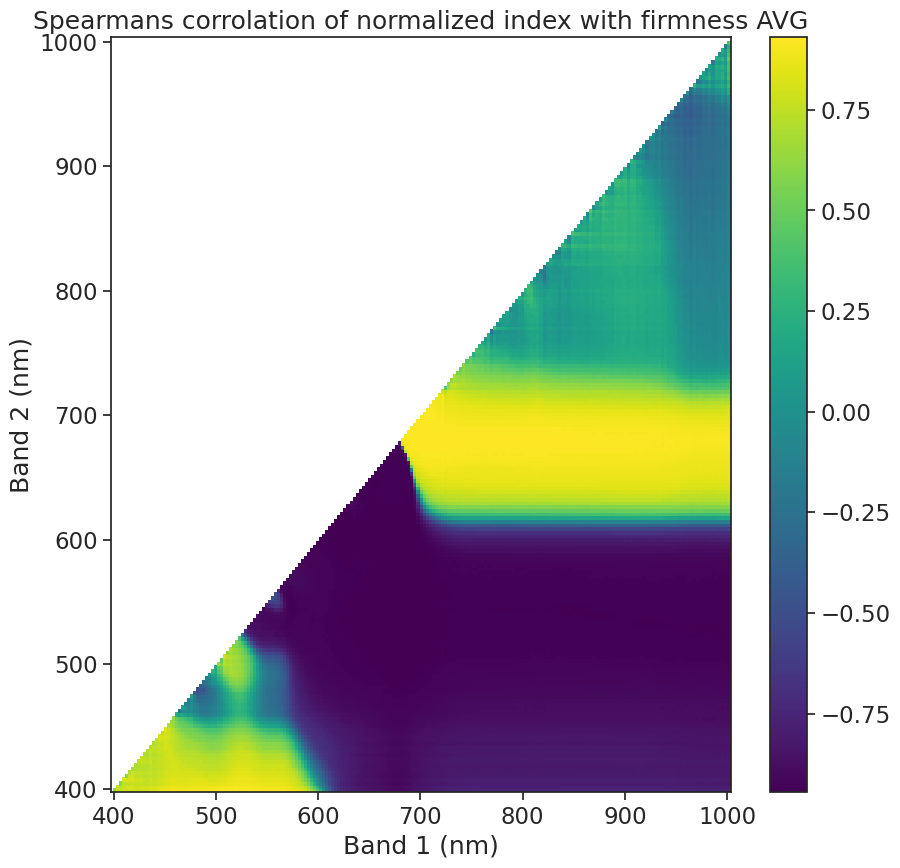

results for % citric acid:
 $$R^2$$ =0.493408203125
 R (max, min)=(0.7026, -0.7026)
 rmse=0.06427001953125/n b1=142/n b2=12


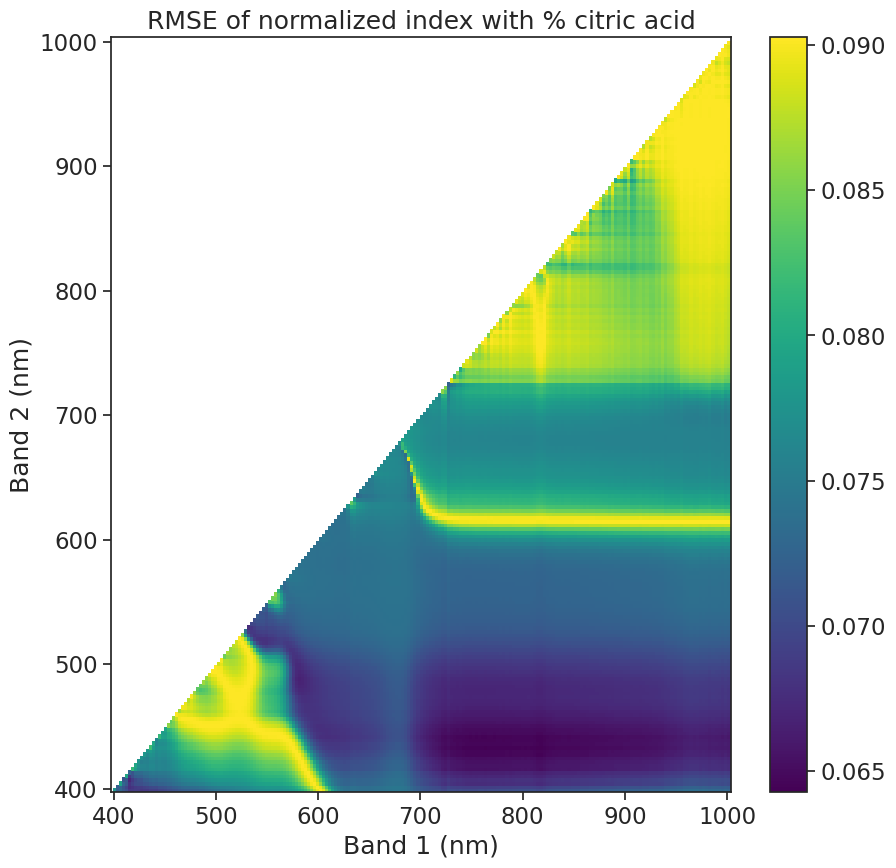

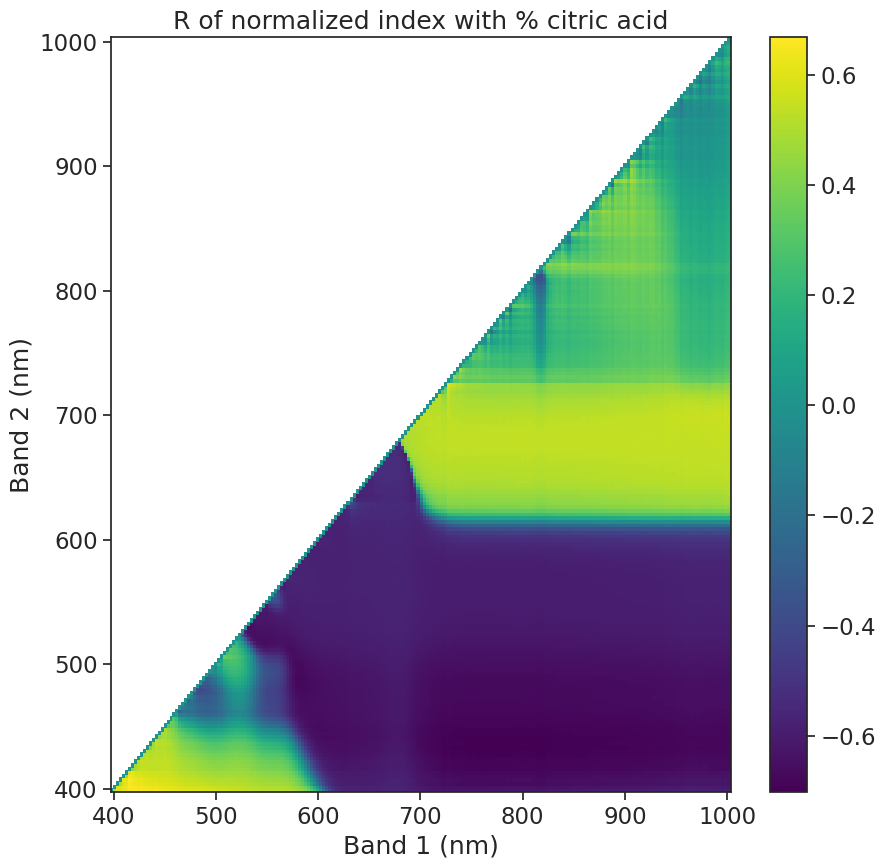

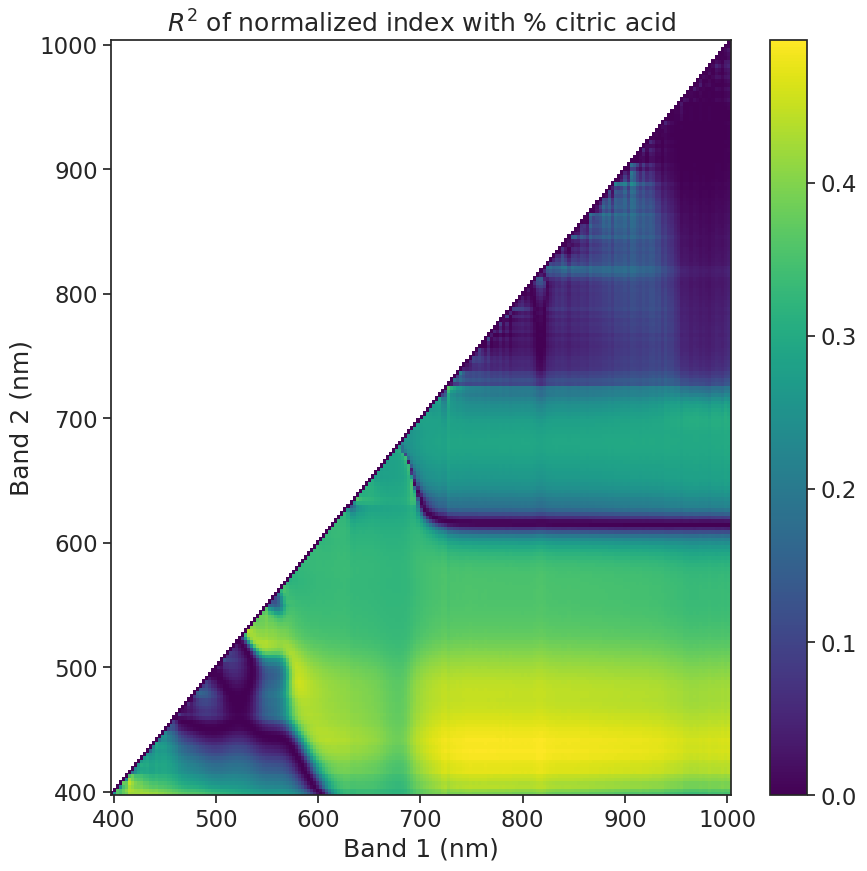

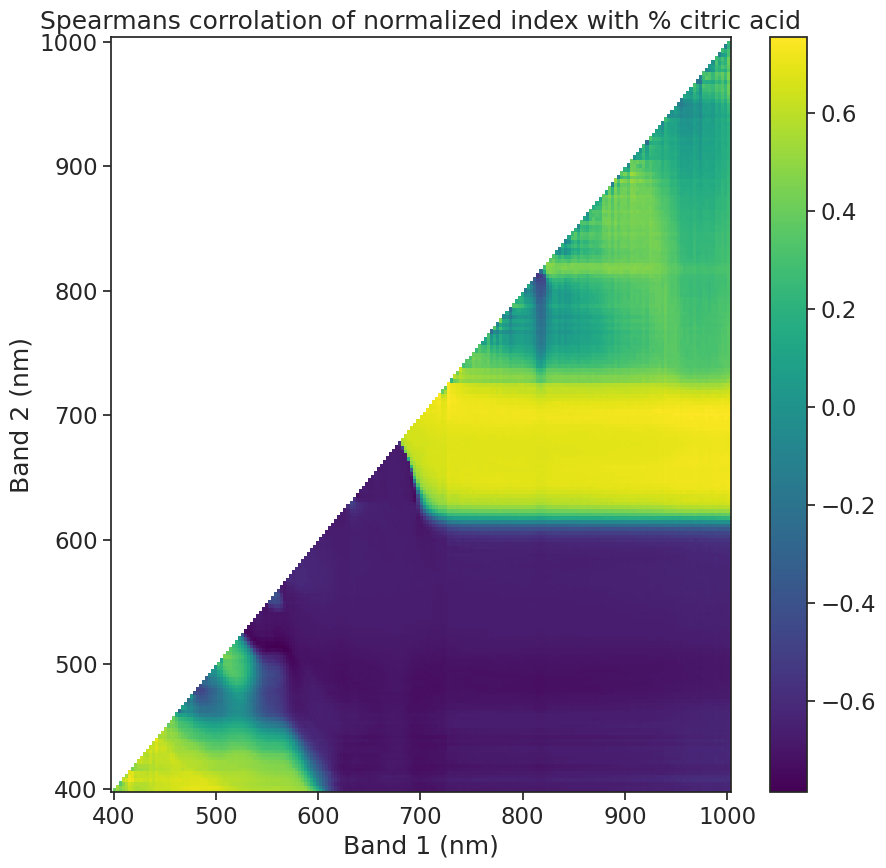

results for pH:
 $$R^2$$ =0.465087890625
 R (max, min)=(0.682, -0.682)
 rmse=0.1416015625/n b1=112/n b2=110


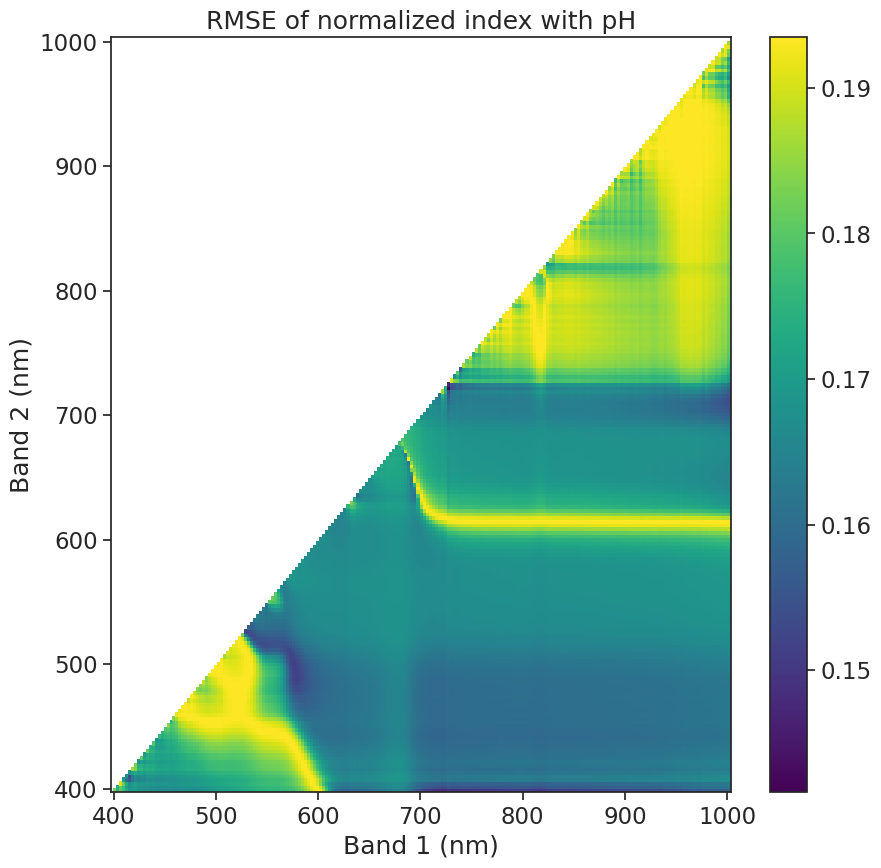

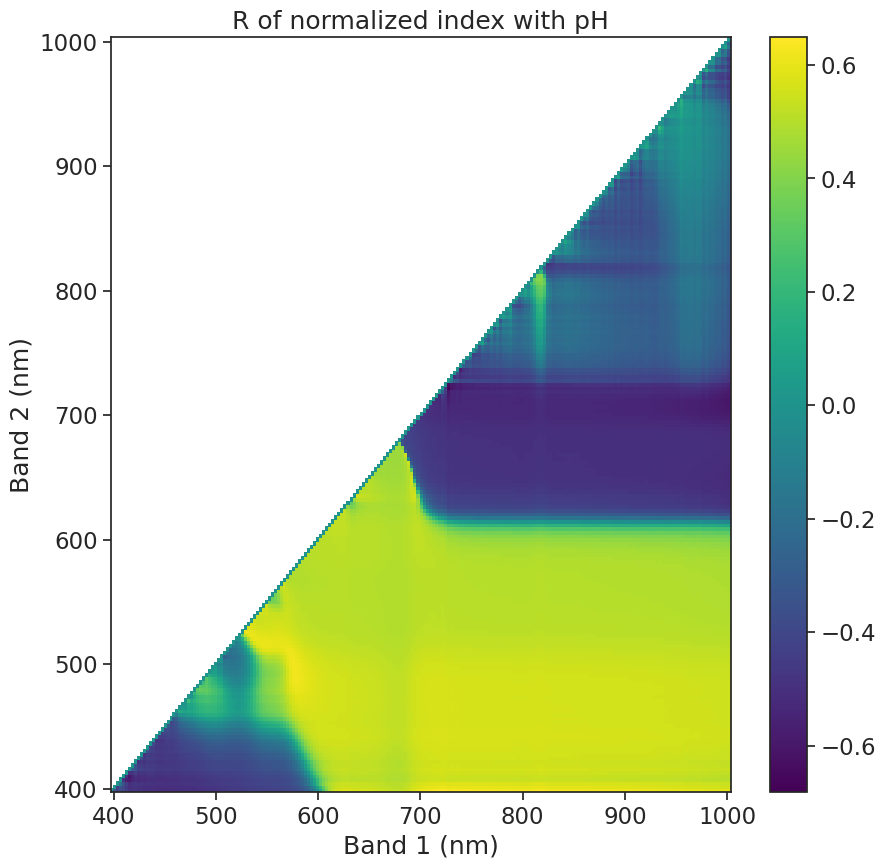

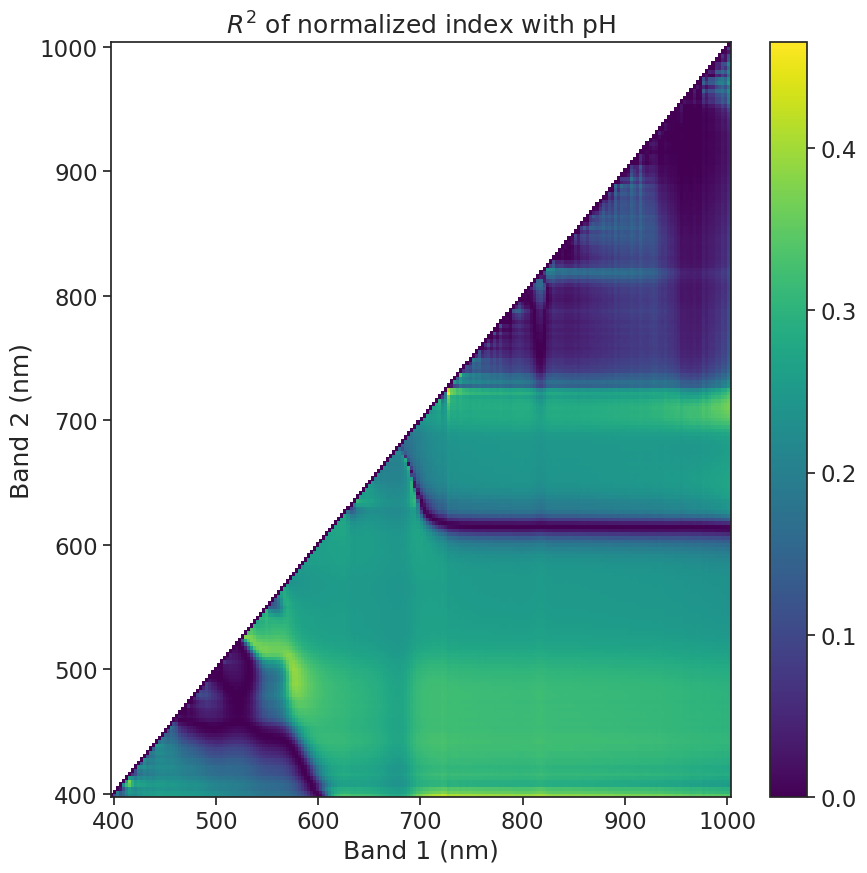

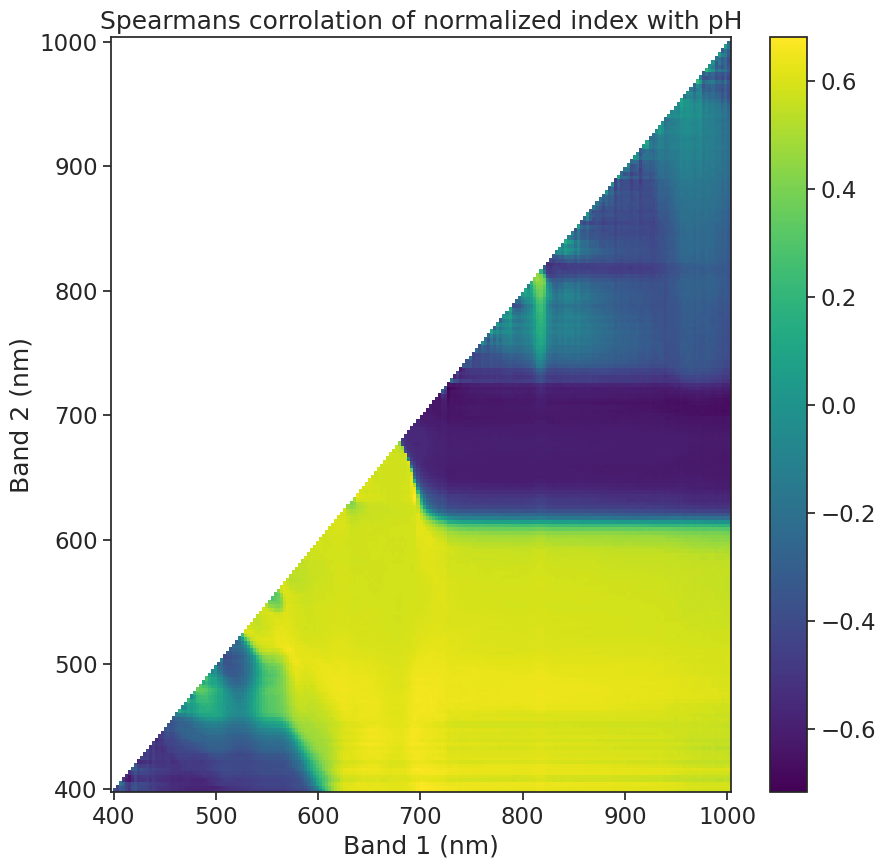

results for TSS:
 $$R^2$$ =0.256103515625
 R (max, min)=(0.506, -0.506)
 rmse=0.224609375/n b1=112/n b2=110


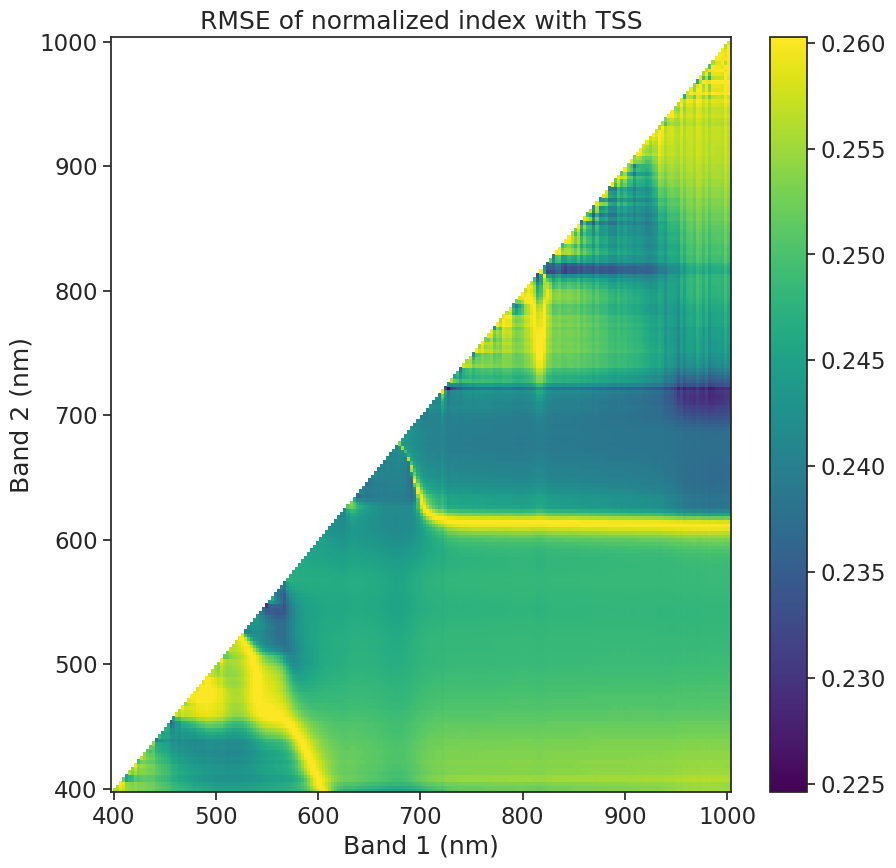

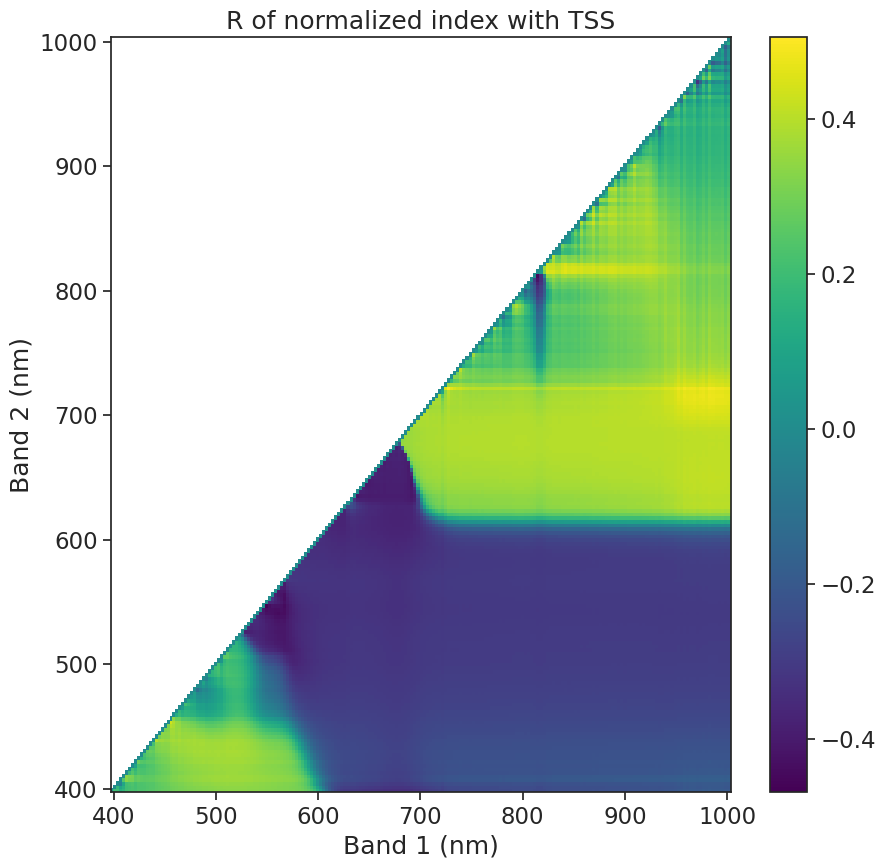

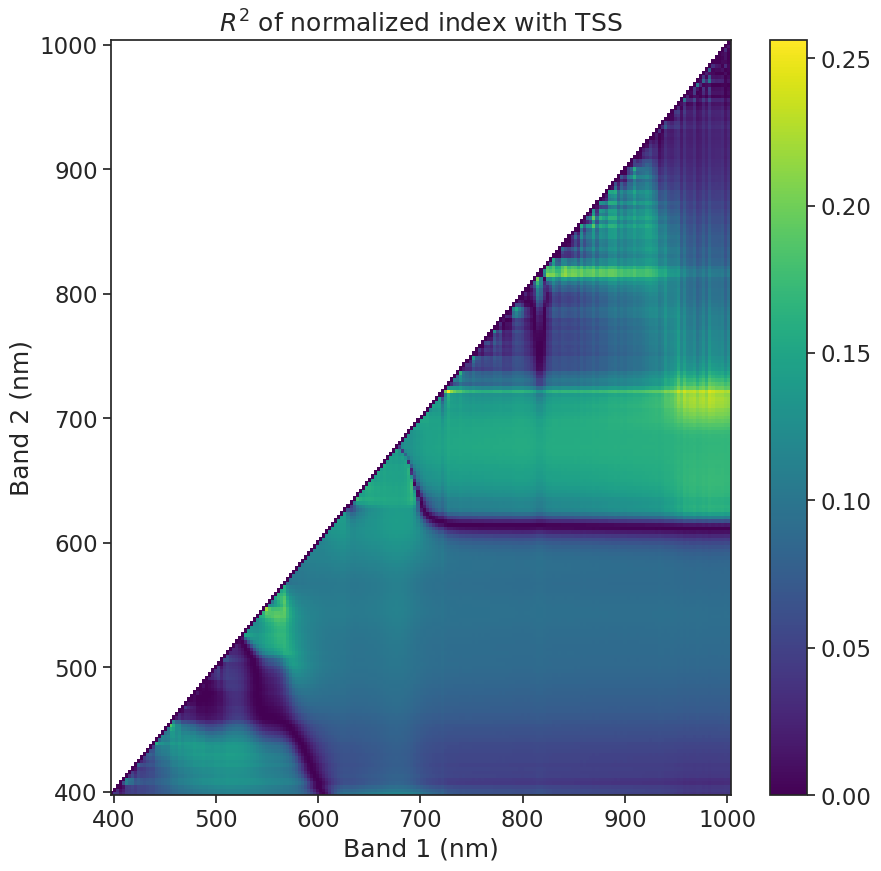

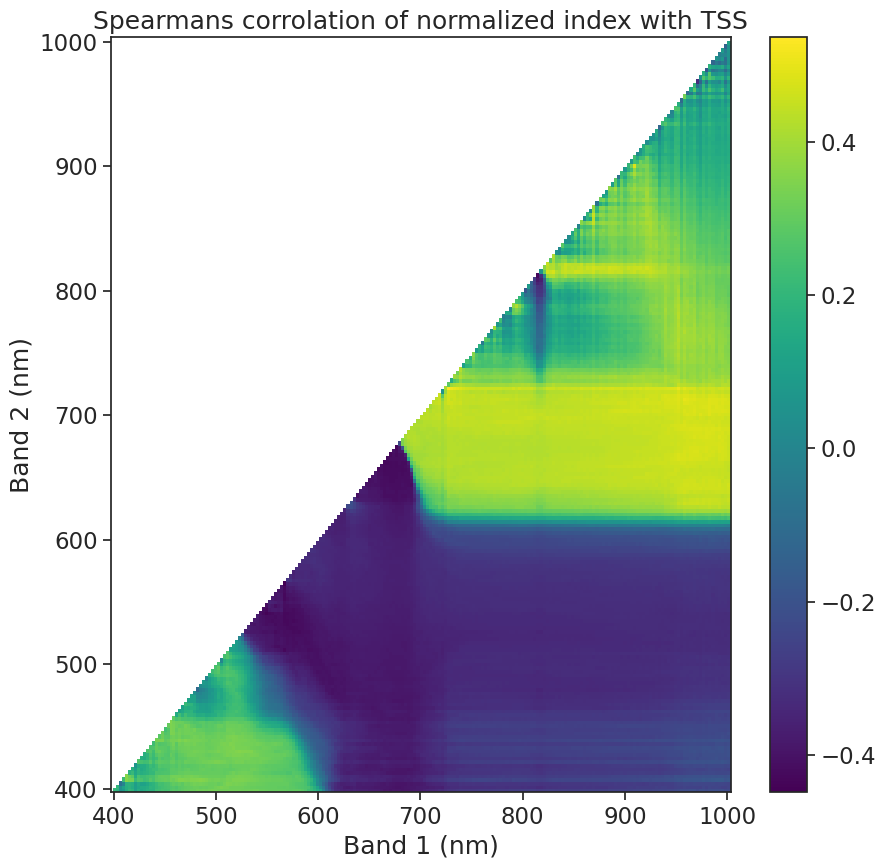

results for ascrobic acid (mg/100g):
 $$R^2$$ =0.24755859375
 R (max, min)=(0.4976, -0.4976)
 rmse=2.109375/n b1=158/n b2=157


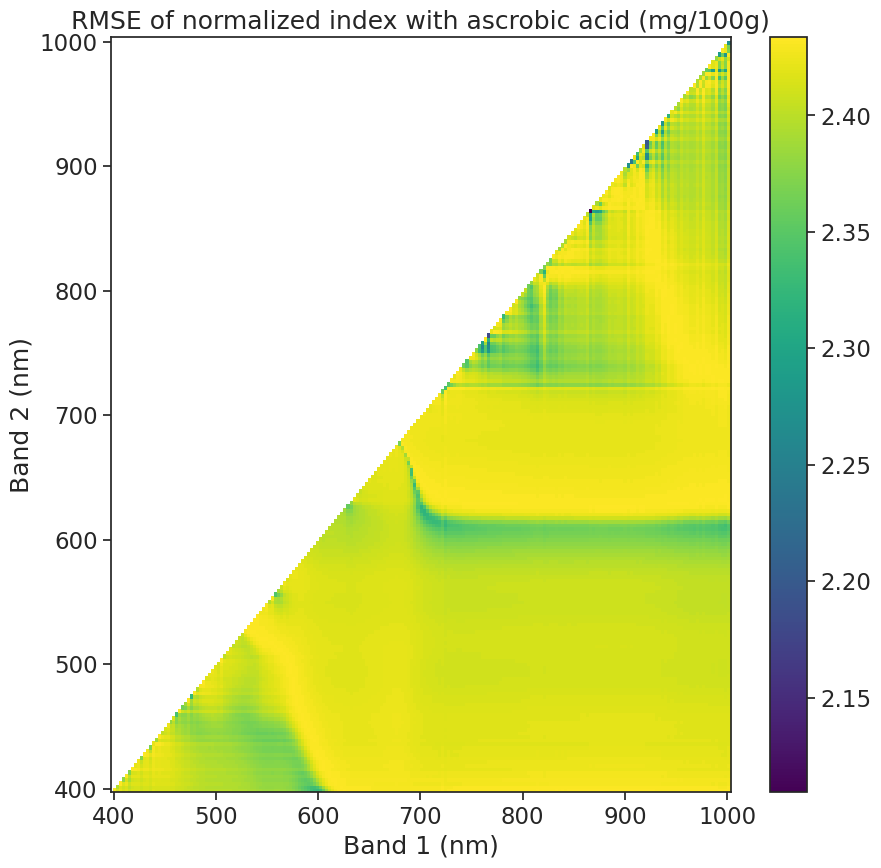

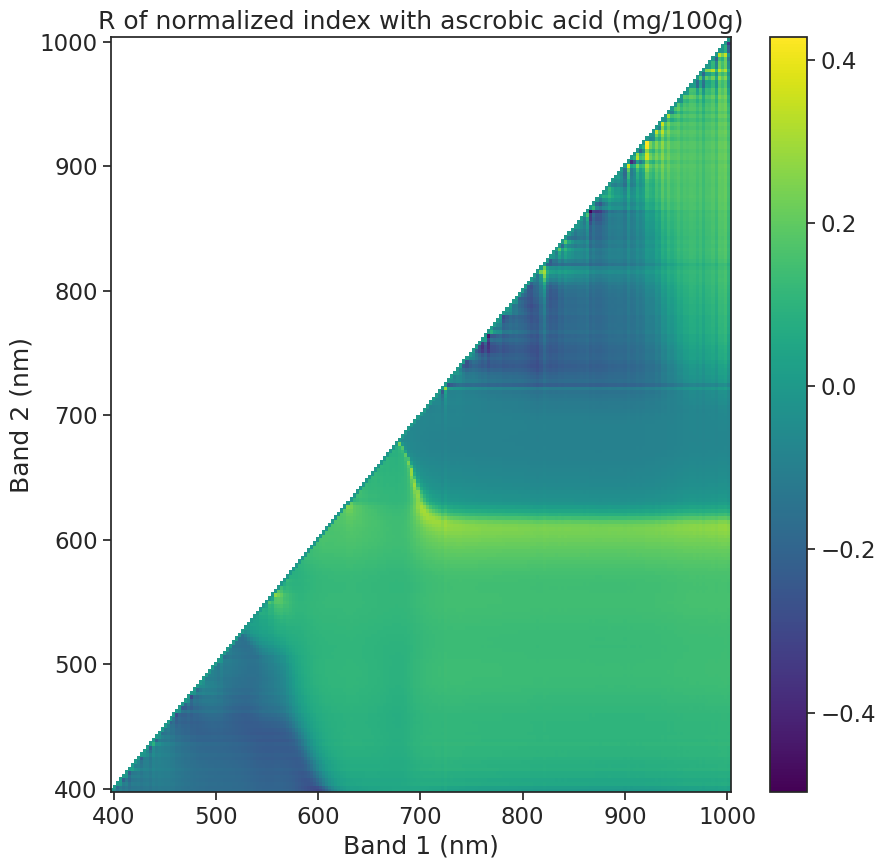

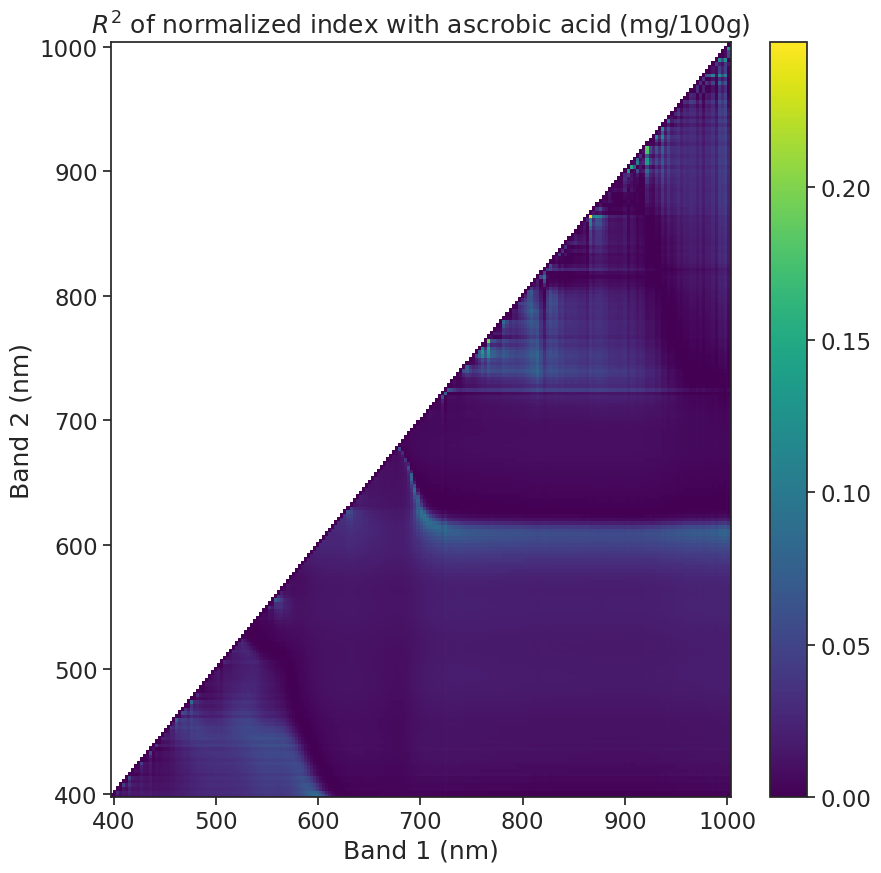

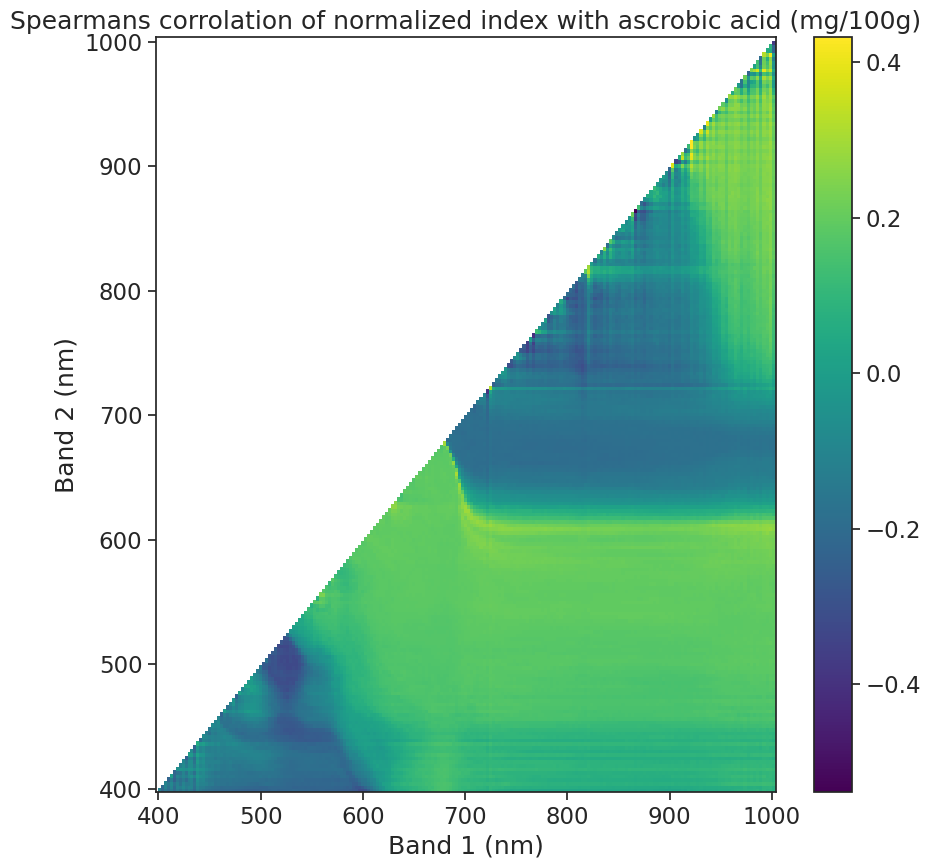

In [ ]:
# viridis = cm.get_cmap('viridis', 256)
B1={}
B2={}
save={}
map_type=['RMSE','R','$R^2$','Spearmans corrolation']
for k,v in soli_2_ref_res.items():
  if k=='ID':
    continue
  r_2,R,rmse,spear,b1,b2=one_result_test(v)
  print(f'results for {k}:\n $$R^2$$ ={r_2.max()}\n R (max, min)={R.max(),R.min()}\n rmse={rmse[~np.isnan(rmse)].min()}/n b1={b1}/n b2={b2}')
  B1[k]=b1
  B2[k]=b2
  save[k]=[rmse,R,r_2,spear]
  stats_names={'1':rmse,'2':R,'3':r_2,'4':spear}
  for j,name in zip(stats_names.values(),map_type):
      plot_examples(j,k,name)

###scatter plots

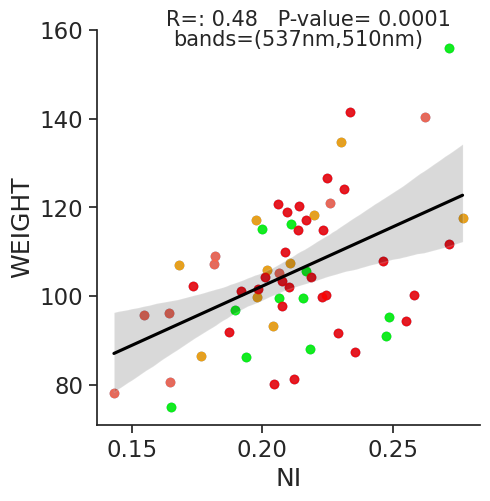

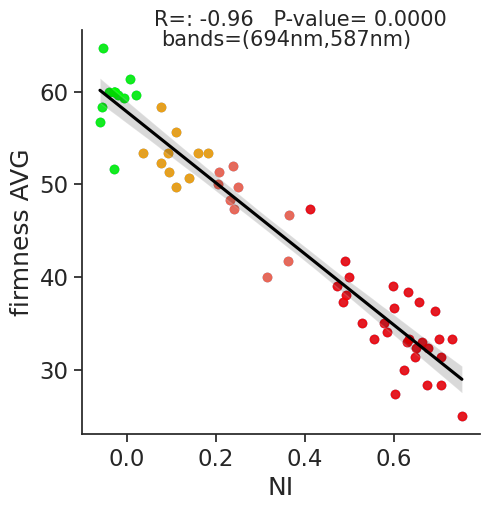

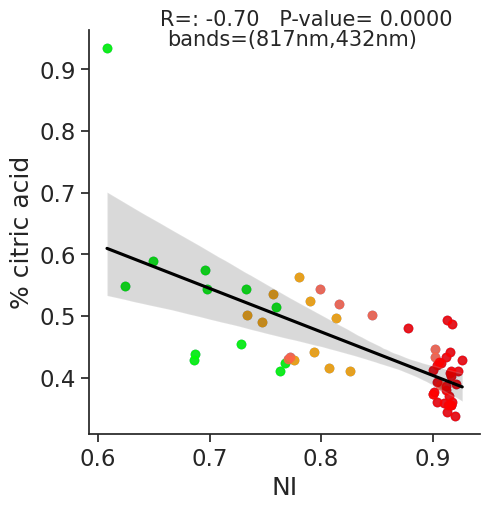

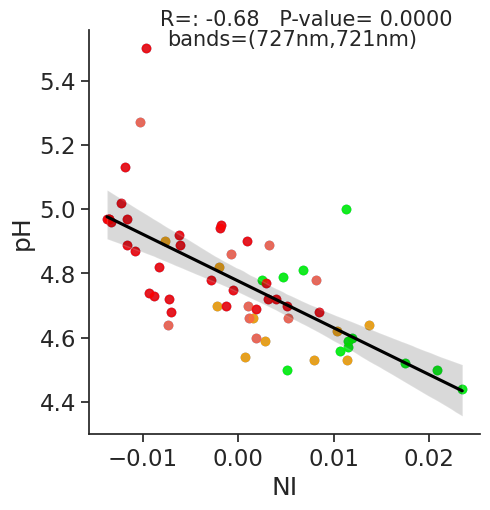

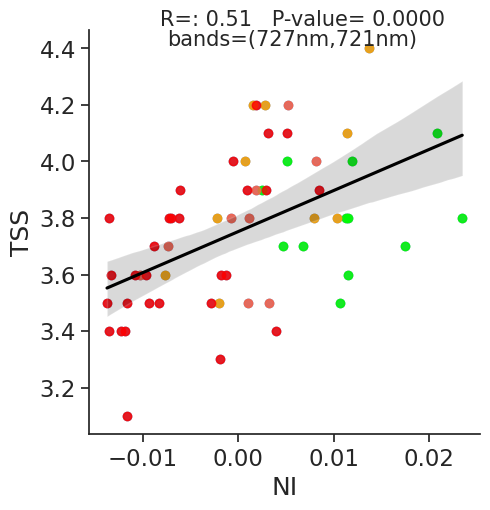

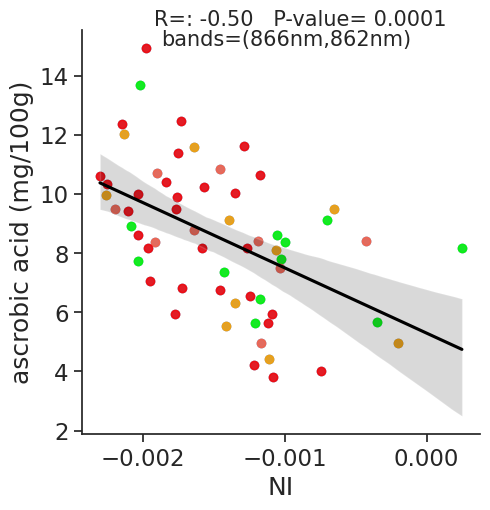

In [ ]:
regretionplot(B1,B2, soli_2_ref_res)

#save color maps

In [ ]:
#save data for R_R2_RMSE
stats_names={'1':rmse,'2':R,'3':r_2,'4':spear}
map_type=['RMSE','R','$R^2$','spearsman corrolation']
for k,name in zip(stats_names.values(),map_type):
  for i,j in zip(range(len(df_results.columns)),list(df_results.columns)):
    temp_df=pd.DataFrame(k[i],columns=waves,index=waves)
    temp_df.to_csv("file location here"+name+"_NI_"+j+".csv")
  

In [ ]:
#save data for one_result_test
map_type=['RMSE','R','$R^2$','spearsman corrolation']
for k,v in save.items():
  for i,name in zip(v,map_type):
        temp_df=pd.DataFrame(i,columns=waves,index=waves)
        temp_df.to_csv("file location here"+name+"_NI_"+k+".csv")
